In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import env
import acquire
import prepare
import os

# turn off warning boxes for demo
import warnings
warnings.filterwarnings("ignore")

Using cached csv


# Project Goal

Identify drivers of customer churn and propose recommendations to improve customer retention. 

This is accomplished by creating a machine learning model that uses multiple features to accurately predict churn.

# Project Description

Telco Communications prides itself on customer satisfaction and quality of service. Maintaing a good reputation comes by focusing efforts on current customer and . After identifying key drivers of churn Telco can then focus on improving customer experience and quality of product.

# Initial Hypothesis/Questions

- Does contract type play a role in churn?
- How long were churned customers with Telco before leaving? 
- Is service type associated with churn? 
- How much does the average customer pay each month?

# Wrangle Telco Data

To acquire the Telco data, from our mySQL server, I used the telco_db and joined all 4 tables together.
- This results in a dataframe containing customers, contract types, payment_types, and internet service options into one new dataframe.

 **Connect to mySQL database and run the query to return the table in the form of a dataframe**

In [2]:
df = acquire.get_telco_data()

Using cached csv


# Prepare

To prepare the data, I created a function that does the following:
- Dummy Vars: Convert all columns to ML friendly values
- Drop columns: dropping columns that are duplicates or not needed
- Drop rows: Where tenure was missing (these rows indicate new customers)  
- Split data: Splits the data into three samples

In [3]:
df.shape

(7043, 24)

In [4]:
train, validate, test = prepare.prep_telco_data(df)

In [5]:
train.shape, validate.shape, test.shape

((3937, 35), (1688, 35), (1407, 35))

- Our data is now split into three samples so that we can explore, fit models, and evaluate without looking at new data.
- The validate sample is used to verify that our models built are not overfit to the train dataset
- The test set is used to give an estimate of how this model will perform on new data 


# Data Context

####  The data is made up of 7,043 customers, 
####  The current churn rate is 27%
####  Most customers will  churn in within their first 10 months 
####  The average rate for customers who churn is higher than the overall 
####  Fiber optic is associated with higher risk of churn

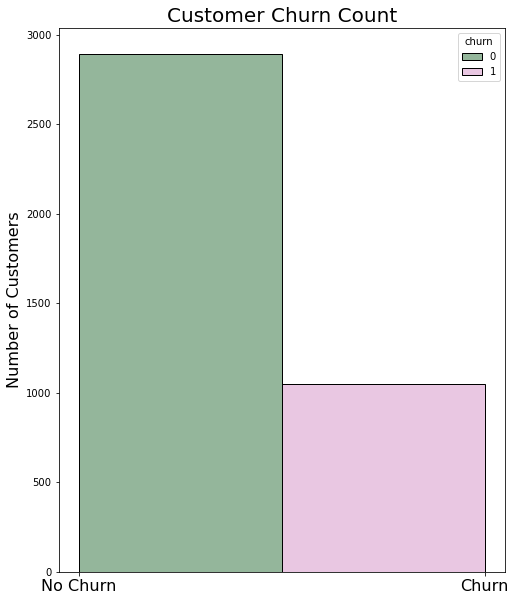

Churned and Non Churn Counts 
1    1046
0    2891
Name: churn, dtype: int64


In [6]:
#  creating a visual for the churn rate of customers in the train data

plt.figure(figsize = (8, 10))
sns.histplot( x = 'churn', hue ='churn', palette = 'cubehelix', data = train, binwidth=.5)
plt.title('Customer Churn Count', fontsize = 20)
plt.xlabel(' ')
plt.xticks([0,1], ['No Churn', 'Churn'], fontsize = 16)
plt.ylabel('Number of Customers', fontsize = 16)
plt.show()

print(f'Churned and Non Churn Counts \n{train.churn.value_counts(ascending = True)}')

# Exploratory Analysis : Who is more likely to Churn?

### Further analysis will answer the following questions: 

### 1. What is the average length of tenure before a customer churns?
### 2. Is service associated with churn?
### 3. Do customers with autopay churn more than those without?
### 4. Do customers who churn pay more than customers who don't churn?

## **Question 1: What is the average length of tenure before customers churn?**

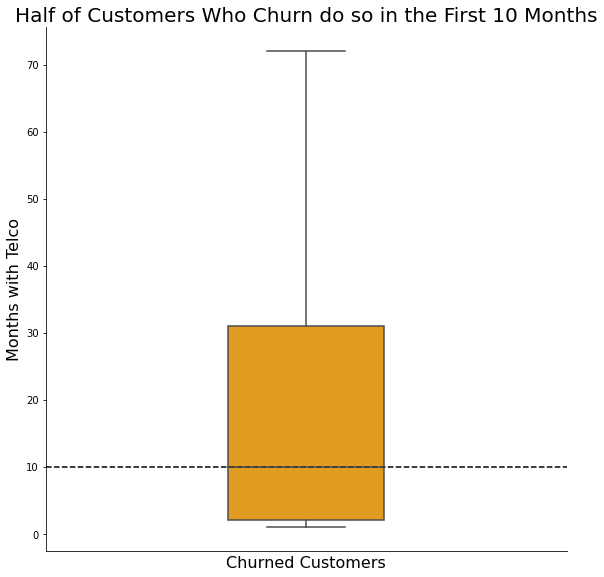

In [7]:
# take a look at the tenure of all contracts types and churn rates
sns.catplot( x= 'churn', y = 'tenure',
            kind = 'box', 
            color = 'orange', size = 8, width = .3,
            data = train[train.churn == 1])


plt.title('Half of Customers Who Churn do so in the First 10 Months', fontsize = 20)
plt.xlabel('Churned Customers', fontsize = 16)
plt.ylabel('Months with Telco', fontsize = 16)
plt.xticks([1], ['Has Churned'])
plt.axhline(y=10, linestyle = '--', color = 'black')
plt.show()

## **Answer 1: Highest percentage of customers who churn will churn within the first 10 months.**

## **Question 2: Is service type associated with churn?**

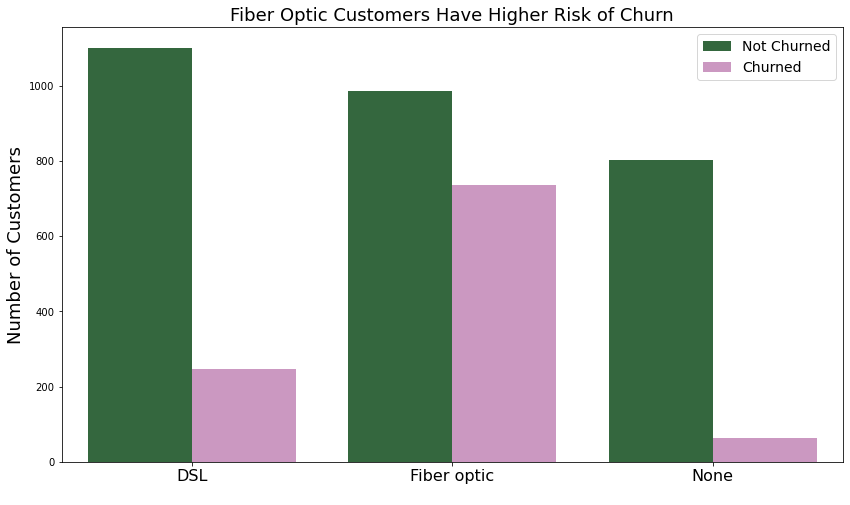

Fiber optic    1722
DSL            1348
None            867
Name: internet_service_type, dtype: int64

In [8]:
# plot visualization of number of customers churned/not churned by internet service type
plt.figure(figsize=(14,8))
sns.countplot(x='internet_service_type', hue ='churn', palette = 'cubehelix', data=train)
plt.title('Fiber Optic Customers Have Higher Risk of Churn', fontsize=18)
plt.legend(labels=['Not Churned','Churned'], fontsize = 14)
plt.xticks(fontsize = 16)
plt.xlabel(' ')
plt.ylabel('Number of Customers', fontsize =18)
plt.show()

train.internet_service_type.value_counts()

## **Answer 2: Customers with Fiber optic are more likely to churn compared to customers without.**

## **Question 3: Is autopay associated with churn?**

## Null Hypothesis - Autopayment plans and churn are independent of each other
## Alternative hypothesis - Autopay and churn are not independent of each other

In [9]:
alpha = .05 

observed = pd.crosstab(train.churn, train.is_autopay)
observed
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('====================\nExpected\n')
print(expected)
print('====================\n')
print(f'chi^2 = {chi2:.2f}')
print(f'p     = {p:.2f}')
if p<alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

Observed

[[1428 1463]
 [ 752  294]]
Expected

[[1600.80772162 1290.19227838]
 [ 579.19227838  466.80772162]]

chi^2 = 156.42
p     = 0.00
We reject the null hypothesis.


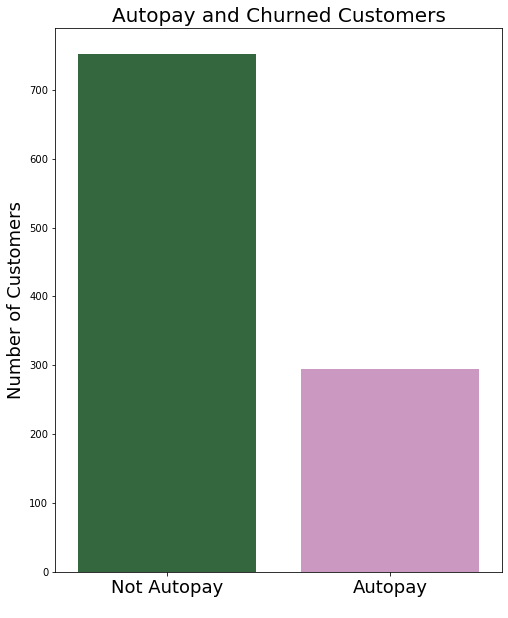

In [10]:
# creating a countplot to compare churned customers payment types

plt.figure(figsize = (8,10)), 
sns.countplot( x = 'is_autopay', palette = 'cubehelix', data = train[train.churn ==1])
plt.title('Autopay and Churned Customers', fontsize=20)

plt.xticks([0, 1], ['Not Autopay', 'Autopay'], fontsize =18)
plt.ylabel('Number of Customers', fontsize =18)
plt.xlabel(' ')
plt.show()


## Answer 3: Non autopayment plans are associated with higher risk of churn

## **Question 4: Do customers who churn pay more than the average customer?**

In [11]:
print(f'The average customer at Telco has a monthly bill of ${train.monthly_charges.mean(): .2f}')

The average customer at Telco has a monthly bill of $ 64.81


### Null Hypothesis: Churned customers had monthly charges equal to or less than all customers

### Alternate Hypothesis: Monthly charges for churned customers are higher than the average monthly rate

## t-test

In [12]:
# Independent groups. Churned vs everyone and comparing monthly charges

alpha = .05
churn_sample = train[train.churn ==1].monthly_charges
overall_mean = train.monthly_charges.mean()

t, p = stats.ttest_1samp(churn_sample, overall_mean)
if p/2 > alpha:
    print('We fail to reject the null hypothesis')
elif t <0:
    print('We fail to reject the null hypothesis')
else:
    print('We reject the null hypothesis')

print(t, p/2, alpha)

We reject the null hypothesis
13.037366230308015 2.0798982128378347e-36 0.05


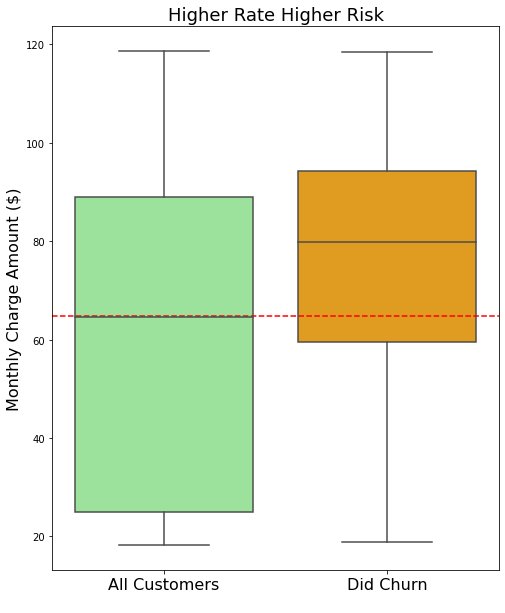

In [13]:
# plot visualization of distribution of monthly charges for those who have churned vs those who have not churned

plt.figure(figsize=(8,10))
sns.boxplot(x='churn', y='monthly_charges', palette = ['lightgreen', 'orange'], data=train )
plt.title('Higher Rate Higher Risk', fontsize=18)
plt.xlabel(' ')
plt.ylabel('Monthly Charge Amount ($)', fontsize = 16)
plt.xticks([0, 1], ['All Customers','Did Churn'], fontsize = 16)
plt.axhline(y = 64.81, linestyle = '--', color='red')
plt.show()

## **Answer 4: If a customer is paying an above average rate they have an above average risk of churn**

# **Key Takeaways/Features from Exploration:**
### - Customers are at highest risk of churn in their first 10 months
### - Customers with Fiber Optic churn at higher rates compared to those without
### - Autopayment plans reduce risk of churn
### - Higher than average monthly rates are associated with churn

# Predicting Churn

### Classification machine learning algorithms will be fit with our training data and evaluated on our validation data. 
### Models are fit with key features drawn from exploration phase:
    - 'tenure', 'monthly_charges', 'total_charges', 'is_autopay', 'phone_service', 'month_to_month_contract', 
    'one_year_contract', 'two_year_contract', 'dsl_internet', 'fiber_optic_internet', 'no_internet_service'
### The model chosen will be based on accuracy because we are working with data that is mostly balanced

# Baseline

### Baseline is a model that predicts the most common outcome (No Churn).
### - Accuracy of the baseline is compared to accuracy of ML models

In [14]:
baseline_accuracy = (train.churn == 0).mean()
print(f' Baseline Accuracy performed at {baseline_accuracy :.2%}')

 Baseline Accuracy performed at 73.43%


### Baseline Accuracy performed at 73.43%. 
### To provide value, the selected model must provide greater accuracy

In [15]:
# Create X and y version of train, y is a series of the target variable and X are all the features. 
# Choosing to select features that my exploration process proved to have strong correlation with churn
drop_cols = ['churn', 'customer_id', 'multiple_lines', 'contract_type', 'internet_service_type', 'payment_type', 'streaming_tv', 
             'streaming_movies', 'mailed_check_nonauto', 'electronic_check_nonauto', 'credit_card_autopay', 'bank_transfer_autopay',
            'has_partner', 'has_dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'no_phone_service', 
             'is_male', 'has_multiple_lines', 'one_line', 'is_senior_citizen', 'paperless_billing']



X_train = train.drop(columns = drop_cols)
y_train = train.churn

X_validate = validate.drop(columns = drop_cols)
y_validate = validate.churn

X_test = test.drop(columns = drop_cols)
y_test = test.churn

# Check the shape of the data to make sure all columns are the same

X_train.shape, X_validate.shape, X_test.shape

((3937, 11), (1688, 11), (1407, 11))

## KNearest Neighbors ML Model

In [16]:
# Evaluate KNearest Neighbors model on train & validate dataset
            
# define the model setting hyperparameter to 8
knn = KNeighborsClassifier(n_neighbors=8)
    
# fit the model on train
knn.fit(X_train, y_train)
    
# use the model and evaluate performance on train
train_accuracy = knn.score(X_train, y_train)
# use the model and evaluate performance on validate
validate_accuracy = knn.score(X_validate, y_validate)
    
print(f'train_accuracy: {train_accuracy: .2%}')
print(f'validate_accuracy: {validate_accuracy: .2%}')

train_accuracy:  81.36%
validate_accuracy:  78.55%


## Random Forest ML Model

In [17]:
# Evaluate Random Forest model on train and validate dataset

# define the model setting hyperparameters to values for current loop
forest = RandomForestClassifier(max_depth=9, min_samples_leaf=9, random_state=123)

# fit the model on train
forest = forest.fit(X_train, y_train)

# use the model and evaluate performance on train
train_accuracy = forest.score(X_train, y_train)
# use the model and evaluate performance on validate
validate_accuracy = forest.score(X_validate, y_validate)

print(f'train_accuracy: {train_accuracy: .2%}')
print(f'validate_accuracy: {validate_accuracy: .2%}')

train_accuracy:  82.83%
validate_accuracy:  77.55%


## Logistic Regression ML model

In [18]:
# Evaluate Logistic Regession model on train and validate dataset

logit = LogisticRegression(C=1)
    
# fit the model on train
logit.fit(X_train, y_train)
    
# use the model and evaluate performance on train
train_accuracy = logit.score(X_train, y_train)
# use the model and evaluate performance on validate
validate_accuracy = logit.score(X_validate, y_validate)

print(f'train_accuracy: {train_accuracy: .2%}')
print(f'validate_accuracy: {validate_accuracy: .2%}')

train_accuracy:  79.65%
validate_accuracy:  78.02%


# EXPECTATION OF MODEL PERFORMANCE

## The logistical regression model proved to be the most accurate.

## An overfit model is not of concern here. 

In [19]:
# Using the most accurate model and performing evaluation on test dataset
print(f' Test accuracy = {logit.score(X_test, y_test): .2%}')

 Test accuracy =  79.96%


## **Test accuracy for this model is _80%_, which is 7% higher than the baseline**

# **CONCLUSION**

## SUMMARY

### Project goals were:
 #### - Identify key drivers of customer churn 
 
 #### - Construct a model that accurately predicts at risk customers
 
### Key drivers of churn were identified as:
####  - Month to month contracts
 
 #### - Higher than average monthly rates
 
####  - Fiber optic internet service
 
#### - Non Autopayment plans
 
### The model is expected to predict at risk customers with 80% accuracy. Using this model on unseen data will help focus retention efforts.


## RECOMMENDATIONS

#### - Incentivize customers with non autopayment plans into an autopay plan

#### - Reduce monthly price for customers who have Fiber Optic

#### - Provide feedback surveys every quarter to help follow emerging trends

## NEXT STEPS

#### - With more time I would like to gather and analyze customer satisfaction reports and apply more feature engineering to improve future models